#1.Loading data, libraries and functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from __future__ import print_function
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPool2D, Lambda, BatchNormalization, Concatenate, AvgPool2D
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow import keras

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib

In [ ]:
# Linking GoogleDrive + accessing data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Verify if subfolders are in TRAIN root folder, 0=Organic, 1=Recyclable, 2=Non Recyclable
DATASET_PATH_TRAIN='gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
for classes in os.listdir(DATASET_PATH_TRAIN):
  d=os.path.join(DATASET_PATH_TRAIN, classes)
  if os.path.isdir(d):
    print(d)

FileNotFoundError: ignored

In [ ]:
# Verify if subfolders are in TEST root folder, 0=Organic, 1=Recyclable, 2=Non Recyclable
DATASET_PATH_TEST='gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank'
for classes in os.listdir(DATASET_PATH_TEST):
  d=os.path.join(DATASET_PATH_TEST, classes)
  if os.path.isdir(d):
    print(d)

gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/0
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/1 
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/2 
gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank/3 


#2 Preprocessing data

In [ ]:
# Defining image height and width
image_height=224
image_width=224
batch_size=32

In [ ]:
path_train = 'gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
path_val = 'gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank'

In [ ]:
def import_dataset(path_train, path_val, image_height, image_width, batch_size):
  # Creating a training dataset
  ds_train = tf.keras.preprocessing.image_dataset_from_directory(
      path_train,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=(image_height,image_width),
      batch_size=batch_size,
      shuffle=True,
      seed=123,
      interpolation='bilinear'
)
  # Creating a validation dataset
  ds_val = tf.keras.preprocessing.image_dataset_from_directory(
      path_val,
      labels='inferred',
      label_mode='int',
      color_mode='rgb',
      image_size=(image_height,image_width),
      batch_size=batch_size,
      shuffle=True,
      seed=123,
      validation_split=val_split,
      subset='validation',
      interpolation='bilinear'
) 
  
  return ds_train, ds_val

In [ ]:
ds_train, ds_val=import_dataset(path_train, path_val, image_height, image_width, batch_size)

Found 4005 files belonging to 4 classes.
Found 1148 files belonging to 4 classes.
Using 801 files for validation.


In [ ]:
def plot_results_loss(r, training_title, label_name_loss, label_name_val_loss, colors):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()

  plt.figure(figsize=(15,8))

  for key,c in zip(r, colors):
    plt.plot(r[key].history['loss'], label= f'{label_name_loss}: {key}', color=c)
    plt.plot(r[key].history['val_loss'], label=f'{label_name_val_loss}: {key}', ls= '--', color=c)
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss [-]')
  plt.title(training_title, fontsize=16, fontweight= 'bold')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
def plot_results_acc(r, training_title, label_name_acc, label_name_val_acc, colors):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set()

  plt.figure(figsize=(15,8))

  for key,c in zip(r, colors):
    plt.plot(r[key].history['accuracy'], label= f'{label_name_acc}: {key}', color=c)
    plt.plot(r[key].history['val_accuracy'], label=f'{label_name_val_acc}: {key}', ls= '--', color=c)
  
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy [-]')
  plt.title(training_title, fontsize=16, fontweight= 'bold')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=20, fontweight='bold')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

#3 Visualization of data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


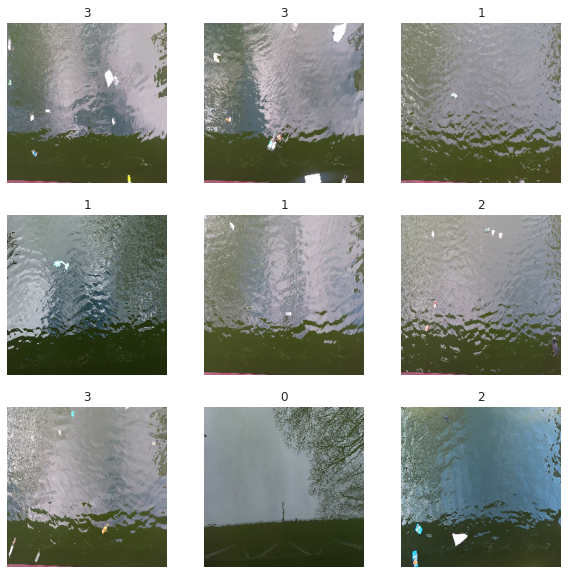

In [ ]:
# Visualizing the TRAIN + VAL DATA
class_names_train = ds_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_train[labels[i]])
    plt.axis("off")

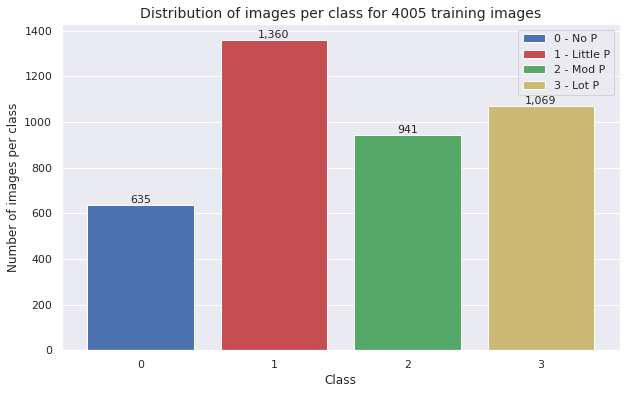

In [ ]:
path = 'gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
folders = os.listdir('gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank') # dir is your directory path
num = []

for folder in folders:
    dir = path + '/' + str(folder)
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    num.append(len(onlyfiles))
    
fig = plt.figure(figsize=(10,6))
classes = ['0', '1', '2', '3']
values = [0, 1, 2, 3]

axes = sns.barplot(x=values, y=num, palette='bright')

for bar, frequency in zip(axes.patches, num):
    text_x = bar.get_x() + bar.get_width() / 2.0  
    text_y = bar.get_height()
    text = f'{frequency:,}'
    axes.text(text_x, text_y, text,fontsize=11,   ha='center', va='bottom')

plt.bar(classes[0], num[0], color='b', label='0 - No P')
plt.bar(classes[1], num[1], color='r', label='1 - Little P')
plt.bar(classes[2], num[2], color='g', label='2 - Mod P')
plt.bar(classes[3], num[3], color='y', label='3 - Lot P')
plt.ylabel('Number of images per class')
plt.xlabel('Class')
plt.title(f'Distribution of images per class for {np.sum(num)} training images', fontsize=14)
plt.legend()
plt.show()

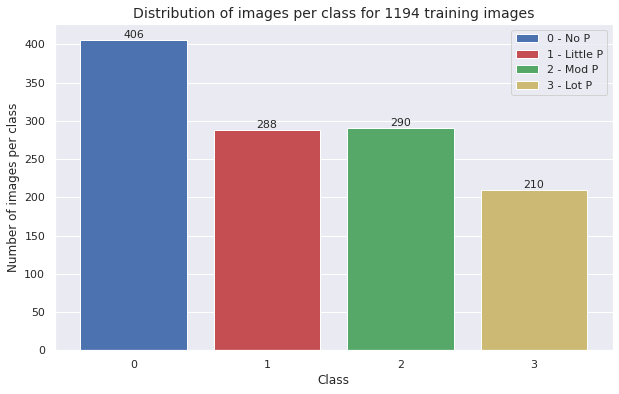

In [ ]:
path = 'gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank'
folders = os.listdir('gdrive/MyDrive/RSDeepLearning/AssWC/test_27m_0deg_center_bank') # dir is your directory path
num = []

for folder in folders:
    dir = path + '/' + str(folder)
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    num.append(len(onlyfiles))
    
fig = plt.figure(figsize=(10,6))
classes = ['0', '1', '2', '3']
values = [0, 1, 2, 3]

axes = sns.barplot(x=values, y=num, palette='bright')

for bar, frequency in zip(axes.patches, num):
    text_x = bar.get_x() + bar.get_width() / 2.0  
    text_y = bar.get_height()
    text = f'{frequency:,}'
    axes.text(text_x, text_y, text,fontsize=11,   ha='center', va='bottom')

plt.bar(classes[0], num[0], color='b', label='0 - No P')
plt.bar(classes[1], num[1], color='r', label='1 - Little P')
plt.bar(classes[2], num[2], color='g', label='2 - Mod P')
plt.bar(classes[3], num[3], color='y', label='3 - Lot P')
plt.ylabel('Number of images per class')
plt.xlabel('Class')
plt.title(f'Distribution of images per class for {np.sum(num)} validation images', fontsize=14)
plt.legend()
plt.show()

#4 Increase of data performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17322586980337324637, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1829339856798333807
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

#5 Model with VGG as baseline

To start developing a CNN model for this study, it is important to have a starting point. As example in terms of model structure, the VGG model is used. The model structure strategy is listed here below:

1. Combination of double conv layers + max pooling                                 
    Opt1: 8 - 16 - 32 - 64                                                                              
    Opt2: 16 - 32 - 64 - 128                                                     
    Opt3: 8 - 16 - 32 - 64 - 128                                                 
    Opt4: 16 - 32 - 64 - 128 - 256                
2. Regularization technique #1 (Dropout) after every max pooling layer and testing different configurations
3. Regularization technique #2 (BatchNorm) 


##5.1 Addressing class imbalance

In [ ]:
path = 'gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank'
folders = os.listdir('gdrive/MyDrive/RSDeepLearning/AssWC/train_27m_0deg_center_bank') # dir is your directory path
num = []

for folder in folders:
    dir = path + '/' + str(folder)
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    num.append(len(onlyfiles))

total_img=np.sum(num)

In [ ]:
num_classes=4
class_weight_train = {0: (total_img/num[0])/num_classes,
                1: (total_img/num[1])/num_classes,
                2: (total_img/num[2])/num_classes,
                3: (total_img/num[3])/num_classes}

In [ ]:
class_weight_train

{0: 1.5767716535433072,
 1: 1.0640276301806588,
 2: 0.7362132352941176,
 3: 0.936623012160898}

##5.2 Configuration of Convolutional + Pooling layers

###5.2.1 Different convolutional block configurations

In [ ]:
def model_vgg(vgg_method):

  """
  The parameter vgg_method defines the configuration of the convolutional blocks that are applied. In total there are 5 combinations.
  Arguments: 'VGG1', 'VGG2', 'VGG3', 'VGG4', 'VGG5'
  """
  num_classes = 4

  if vgg_method=='VGG1':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if vgg_method=='VGG2':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if vgg_method=='VGG3':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if vgg_method=='VGG4':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if vgg_method=='VGG5':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(8, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

In [ ]:
vggs = ['VGG1', 'VGG2', 'VGG3', 'VGG4', 'VGG5']
r_vggs = dict()

for vgg in vggs:
  print(f'Training model with VGG = {vgg}')
  model=model_vgg(vgg_method=vgg)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_vggs[vgg] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)
  err, acc = model.evaluate(ds_val)
  print(f'Model with VGG configuration = {vgg} has a test loss of {round(err, 2)} and an accuracy of {round(acc*100, 2)}%')

Training model with VGG = VGG1
Epoch 1/30
126/126 [==============================] - 1399s 3s/step - loss: 1.3237 - accuracy: 0.3379 - val_loss: 1.4285 - val_accuracy: 0.2658
Epoch 2/30
126/126 [==============================] - 4s 31ms/step - loss: 1.1286 - accuracy: 0.4643 - val_loss: 1.4021 - val_accuracy: 0.2671
Epoch 3/30
126/126 [==============================] - 4s 30ms/step - loss: 1.0061 - accuracy: 0.5159 - val_loss: 1.4172 - val_accuracy: 0.2919
Epoch 4/30
126/126 [==============================] - 4s 30ms/step - loss: 0.9084 - accuracy: 0.5849 - val_loss: 1.4757 - val_accuracy: 0.2969
Epoch 5/30
126/126 [==============================] - 4s 30ms/step - loss: 0.8312 - accuracy: 0.6167 - val_loss: 1.5656 - val_accuracy: 0.2919
Epoch 6/30
126/126 [==============================] - 4s 31ms/step - loss: 0.7368 - accuracy: 0.6866 - val_loss: 1.5854 - val_accuracy: 0.3006
Epoch 7/30
126/126 [==============================] - 4s 30ms/step - loss: 0.6584 - accuracy: 0.7201 - val_los

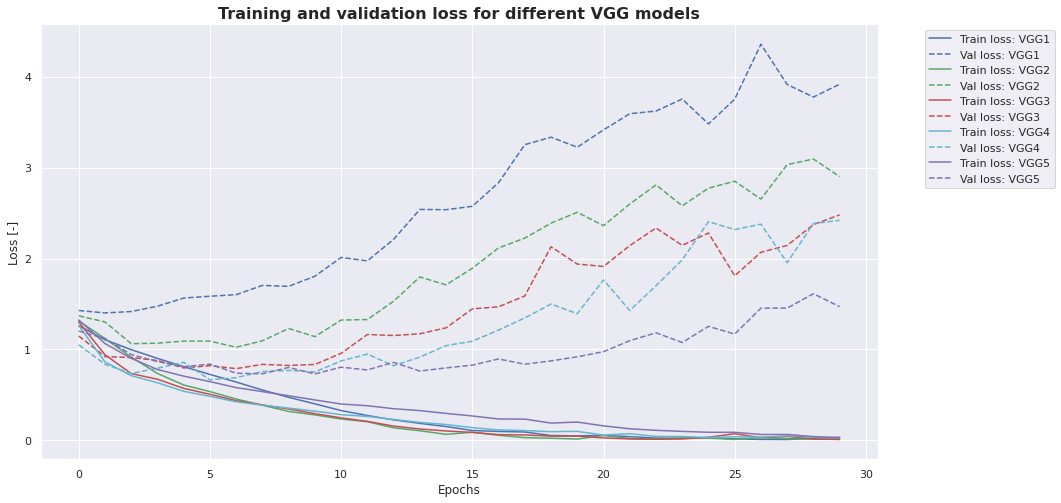

In [ ]:
plot_results_loss(r_vggs, 'Training and validation loss for different VGG models', 'Train loss', 'Val loss', ['b', 'g', 'r', 'c', 'm'])

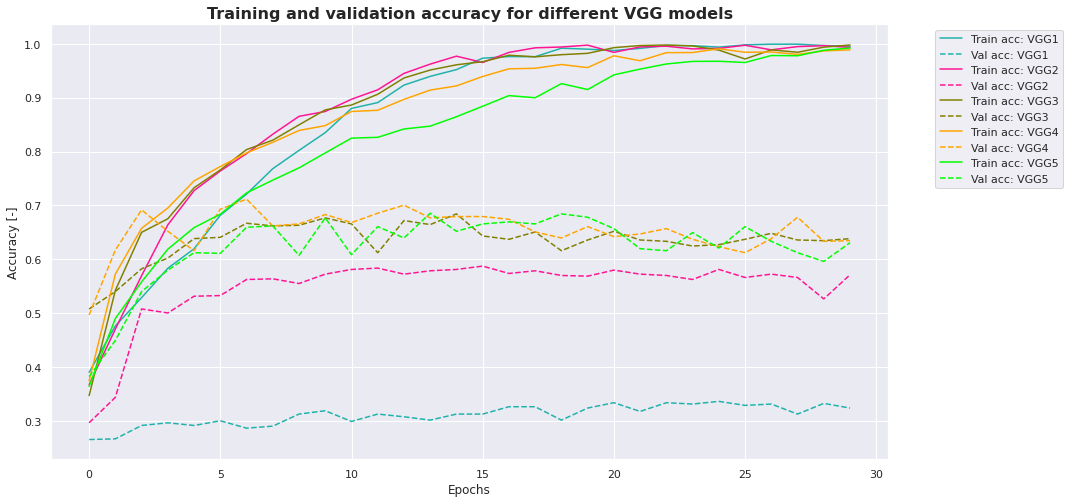

In [ ]:
plot_results_acc(r_vggs, 'Training and validation accuracy for different VGG models', 'Train acc', 'Val acc', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime'])

In [ ]:
for vgg in vggs:
  val_acc = round(np.max(r_vggs[vgg].history['val_accuracy'])*100, 2)
  val_loss = round(np.min(r_vggs[vgg].history['val_loss']), 2)
  print(f'The best validation accuracy of {vgg} is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of VGG1 is 33.66% and validation loss is 1.4
The best validation accuracy of VGG2 is 58.76% and validation loss is 1.02
The best validation accuracy of VGG3 is 68.45% and validation loss is 0.79
The best validation accuracy of VGG4 is 71.18% and validation loss is 0.67
The best validation accuracy of VGG5 is 68.57% and validation loss is 0.73


The learning rate had to be set to 0.0001, because VGG2+3 model got stuck in a local minimum (validation accuracy did not improve) with a learning rate of 0.001. 

Model VGG4 will be chosen, since it has the highest validation accuracy and also least amount of overfitting together with VGG1 and VGG5. 

###5.2.2 Max or Average pooling

In [ ]:
ds_train, ds_val=import_dataset(224, 224, 32)

Found 4005 files belonging to 4 classes.
Found 1194 files belonging to 4 classes.
Using 801 files for validation.


In [ ]:
def hybrid_pool_layer():
    def apply(x):
        return Concatenate()([
                MaxPool2D()(x),
                AvgPool2D()(x)])
    return apply

In [ ]:
def model_pooling(pooling):

  """
  The parameter vgg_method defines the configuration of the convolutional blocks that are applied. In total there are 5 combinations.
  Arguments: 'Max Pooling', 'Average Pooling'
  """
 
  num_classes=4

  if pooling=='Max Pooling':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.MaxPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if pooling=='Average Pooling':
    model = keras.Sequential([
      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.AvgPool2D(),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.AvgPool2D(),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.AvgPool2D(),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.AvgPool2D(),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'),
      keras.layers.AvgPool2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax')
  ])
    
    return model

  if pooling=='Hybrid Pooling': 
    i = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = hybrid_pool_layer()(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = hybrid_pool_layer()(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = hybrid_pool_layer()(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = hybrid_pool_layer()(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = hybrid_pool_layer()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i, x)  

    return model

In [ ]:
pools = ['Max Pooling', 'Average Pooling', 'Hybrid Pooling']
r_pool = dict()

for pool in pools:
  print(f'Training model with pooling method = {pool}')
  model=model_pooling(pooling=pool)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_pool[pool] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)

Training model with pooling method = Max Pooling
Epoch 1/30
126/126 [==============================] - 2300s 3s/step - loss: 1.3528 - accuracy: 0.2987 - val_loss: 1.0338 - val_accuracy: 0.5031
Epoch 2/30
126/126 [==============================] - 9s 73ms/step - loss: 0.9672 - accuracy: 0.5091 - val_loss: 0.8759 - val_accuracy: 0.5752
Epoch 3/30
126/126 [==============================] - 9s 74ms/step - loss: 0.7737 - accuracy: 0.5996 - val_loss: 0.8122 - val_accuracy: 0.6236
Epoch 4/30
126/126 [==============================] - 9s 75ms/step - loss: 0.6659 - accuracy: 0.6801 - val_loss: 0.7298 - val_accuracy: 0.6634
Epoch 5/30
126/126 [==============================] - 10s 76ms/step - loss: 0.5946 - accuracy: 0.7112 - val_loss: 0.6848 - val_accuracy: 0.6832
Epoch 6/30
126/126 [==============================] - 10s 77ms/step - loss: 0.5204 - accuracy: 0.7448 - val_loss: 0.6597 - val_accuracy: 0.7242
Epoch 7/30
126/126 [==============================] - 10s 78ms/step - loss: 0.4636 - accur

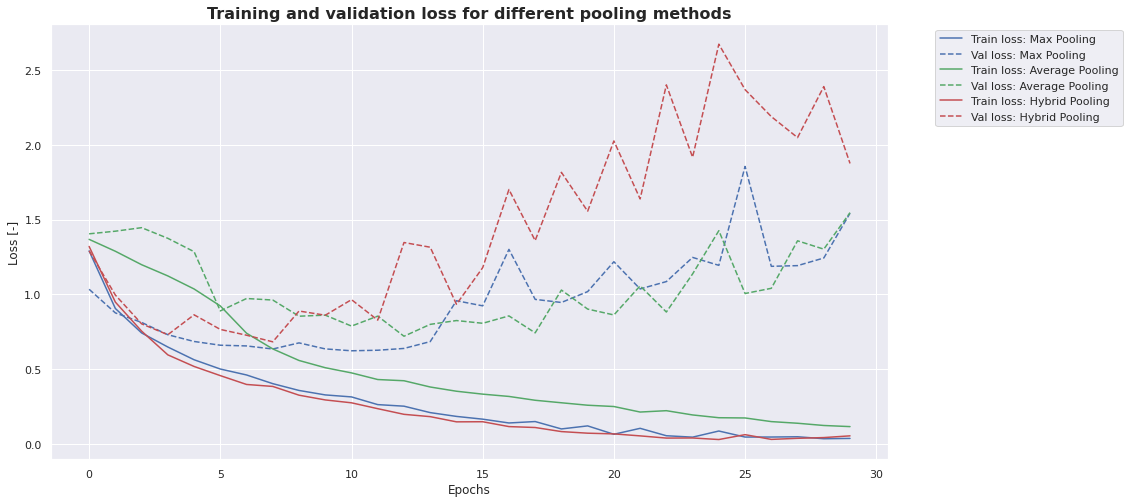

In [ ]:
plot_results_loss(r_pool, 'Training and validation loss for different pooling methods', 'Train loss', 'Val loss', ['b', 'g', 'r', 'c', 'm'])

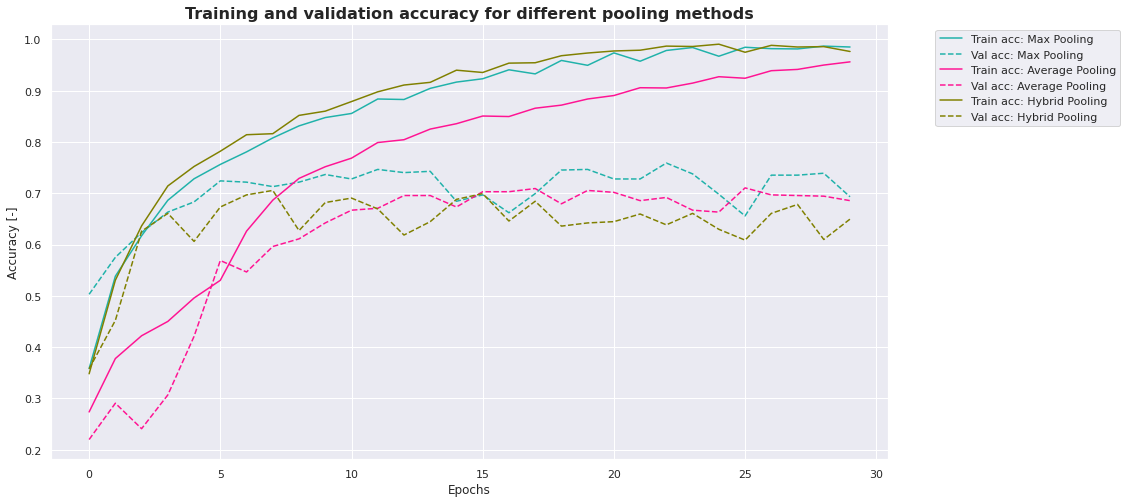

In [ ]:
plot_results_acc(r_pool, 'Training and validation accuracy for different pooling methods', 'Train acc', 'Val acc', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime'])

In [ ]:
for pool in pools:
  val_acc = round(np.max(r_pool[pool].history['val_accuracy'])*100, 2)
  val_loss = round(np.min(r_pool[pool].history['val_loss']), 2)
  print(f'The best validation accuracy of {pool} is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of Max Pooling is 75.9% and validation loss is 0.62
The best validation accuracy of Average Pooling is 71.06% and validation loss is 0.72
The best validation accuracy of Hybrid Pooling is 70.56% and validation loss is 0.68


From the results it can be seen that the use of max pooling perfomrs better. The convergence process for average pooling layers is much slower compared to max pooling, therefore max pooling will be used for the following operations. Max pooling performs better compared to hybrid pooling in terms of loss, overfitting and best validation accuracy. 

##5.3 Assessment of regularization techniques (BatchNorm + Dropout), Dense layers, Global Max+Average Pooling and batch sizes

###5.3.1 Batch Normalization

In [ ]:
def model_batchnorm(momentum):


  """
  
  """
  num_classes = 4
  i = Input(shape=(image_height, image_width, 3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=momentum)(x)
  x = MaxPool2D()(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=momentum)(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=momentum)(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=momentum)(x)
  x = MaxPool2D()(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=momentum)(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(i,x)

  
  return model

In [ ]:
momentums = [0.5, 0.6, 0.7, 0.8, 0.9]
r_batch32 = dict()

for momentum in momentums:
  print(f'Training model with momentum = {momentum} for batch size = 32')
  model = model_batchnorm(momentum=momentum)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_batch32[momentum] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)

Training model with momentum = 0.5 for batch size = 32
Epoch 1/30
126/126 [==============================] - 27s 197ms/step - loss: 2.7562 - accuracy: 0.3712 - val_loss: 0.9309 - val_accuracy: 0.5468
Epoch 2/30
126/126 [==============================] - 24s 193ms/step - loss: 0.7470 - accuracy: 0.6441 - val_loss: 0.8849 - val_accuracy: 0.5993
Epoch 3/30
126/126 [==============================] - 24s 193ms/step - loss: 0.5080 - accuracy: 0.7531 - val_loss: 0.7786 - val_accuracy: 0.6355
Epoch 4/30
126/126 [==============================] - 24s 193ms/step - loss: 0.4354 - accuracy: 0.7891 - val_loss: 0.8531 - val_accuracy: 0.6380
Epoch 5/30
126/126 [==============================] - 24s 193ms/step - loss: 0.3865 - accuracy: 0.8134 - val_loss: 1.0413 - val_accuracy: 0.5730
Epoch 6/30
126/126 [==============================] - 24s 193ms/step - loss: 0.3833 - accuracy: 0.8084 - val_loss: 0.7517 - val_accuracy: 0.6891
Epoch 7/30
126/126 [==============================] - 24s 193ms/step - loss

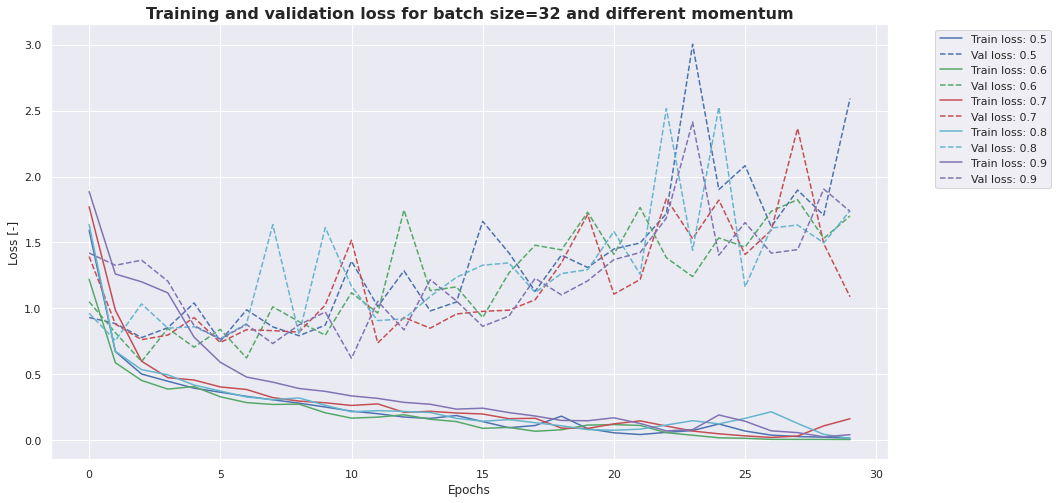

In [ ]:
plot_results_loss(r_batch32, 'Training and validation loss for batch size=32 and different momentum', 'Train loss', 'Val loss', ['b', 'g', 'r', 'c', 'm', 'lime', 'magenta'])

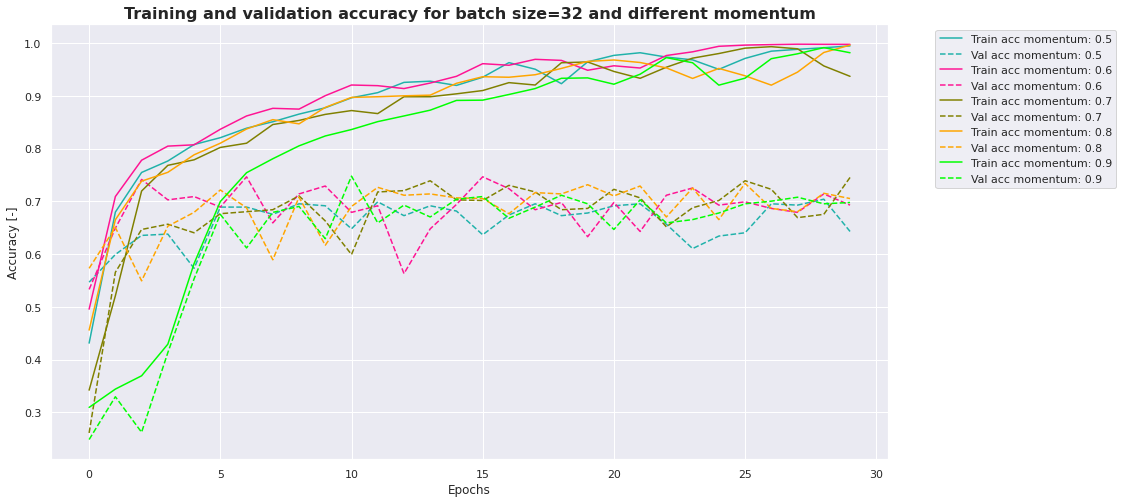

In [ ]:
plot_results_acc(r_batch32, 'Training and validation accuracy for batch size=32 and different momentum', 'Train acc momentum', 'Val acc momentum', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime', 'black'])

In [ ]:
momentums = [0.5, 0.6, 0.7, 0.8, 0.9]
for momentum in momentums:
  val_acc = round(np.max(r_batch32[momentum].history['val_accuracy'])*100, 2)
  val_loss = round(np.min(r_batch32[momentum].history['val_loss']), 2)
  print(f'The best validation accuracy of {momentum} is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of 0.5 is 70.41% and validation loss is 0.75
The best validation accuracy of 0.6 is 74.66% and validation loss is 0.6
The best validation accuracy of 0.7 is 74.53% and validation loss is 0.74
The best validation accuracy of 0.8 is 73.41% and validation loss is 0.76
The best validation accuracy of 0.9 is 74.78% and validation loss is 0.62


By default, momentum would be set a high value about 0.99, meaning high lag and slow learning. The model results show, that by using a lower momentum, that the lag is lower and the learning increases. However, changing the momentum term does not seem to have a large influence. A momentum of 0.6 gives the highest validation accuracy. Furthermore it can be seen that overfitting already takes place after 2-3 epochs, indicating that the model needs regularization or more training data is needed. The use of Batch Normalization seems to reduce the internal covariate shift and also increases the validation accuracy from 73.17% to 78.76%. 



###5.3.2 Dropout

In [ ]:
def model_dropout(dp_value):

  """
  
  """
  num_classes = 4

  i = Input(shape=(image_height, image_width, 3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dropout(dp_value)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(dp_value)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(i,x)
  
  return model

In [ ]:
dropouts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r_dropout32 = dict()

for dropout in dropouts:
  print(f'Training model with dropout = {dropout} for batch size = 32')
  model = model_dropout(dp_value=dropout)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_dropout32[dropout] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)

Training model with dropout = 0.2 for batch size = 32
Epoch 1/30
126/126 [==============================] - 24s 184ms/step - loss: 2.0671 - accuracy: 0.4081 - val_loss: 0.8343 - val_accuracy: 0.6030
Epoch 2/30
126/126 [==============================] - 23s 181ms/step - loss: 0.6955 - accuracy: 0.6528 - val_loss: 0.9971 - val_accuracy: 0.5605
Epoch 3/30
126/126 [==============================] - 23s 180ms/step - loss: 0.6091 - accuracy: 0.6899 - val_loss: 0.7834 - val_accuracy: 0.6417
Epoch 4/30
126/126 [==============================] - 23s 180ms/step - loss: 0.5450 - accuracy: 0.7210 - val_loss: 0.7214 - val_accuracy: 0.6542
Epoch 5/30
126/126 [==============================] - 23s 180ms/step - loss: 0.4657 - accuracy: 0.7771 - val_loss: 0.7164 - val_accuracy: 0.6891
Epoch 6/30
126/126 [==============================] - 23s 180ms/step - loss: 0.4579 - accuracy: 0.7835 - val_loss: 0.8773 - val_accuracy: 0.6392
Epoch 7/30
126/126 [==============================] - 23s 180ms/step - loss:

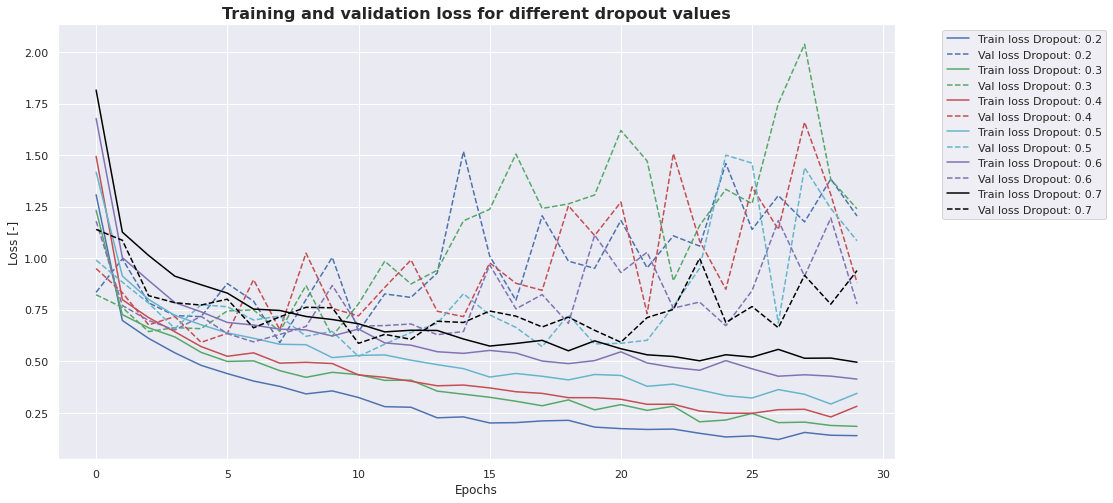

In [ ]:
plot_results_loss(r_dropout32, 'Training and validation loss for different dropout values', 'Train loss Dropout', 'Val loss Dropout', ['b', 'g', 'r', 'c', 'm', 'black'])

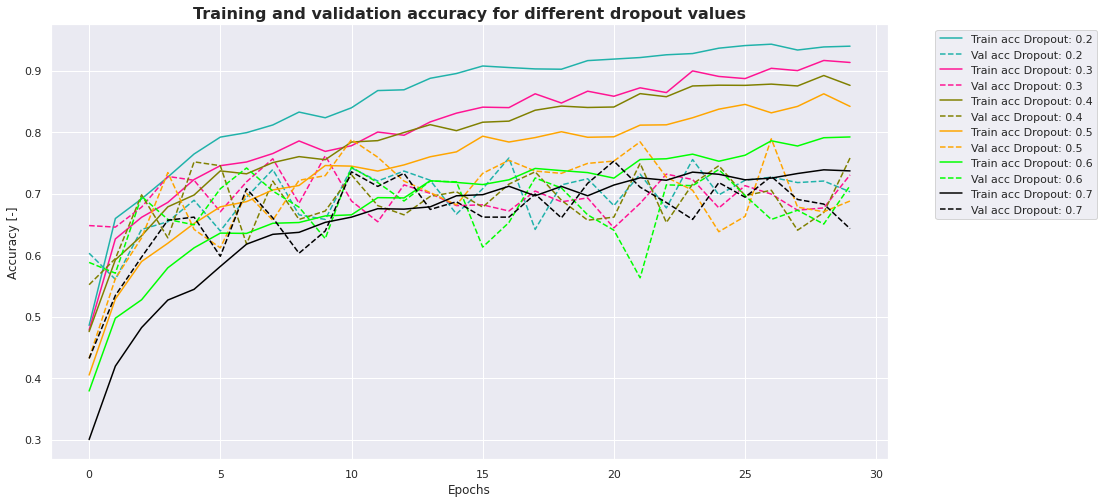

In [ ]:
plot_results_acc(r_dropout32, 'Training and validation accuracy for different dropout values', 'Train acc Dropout', 'Val acc Dropout', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime', 'black', 'yellow'])

In [ ]:
for dropout in dropouts:
  val_acc = round(np.max(r_dropout32[dropout].history['val_accuracy'])*100, 2)
  val_loss = round(np.min(r_dropout32[dropout].history['val_loss']), 2)
  print(f'The best validation accuracy of {dropout} is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of 0.2 is 75.78% and validation loss is 0.59
The best validation accuracy of 0.3 is 76.15% and validation loss is 0.62
The best validation accuracy of 0.4 is 75.78% and validation loss is 0.59
The best validation accuracy of 0.5 is 78.9% and validation loss is 0.52
The best validation accuracy of 0.6 is 74.28% and validation loss is 0.59
The best validation accuracy of 0.7 is 75.28% and validation loss is 0.59


From the graphs it can be seen, that the application of dropout before and after the fully-connected layer has a clear regularization effect, since overfitting is strongly reduced. The best values for reducing overfitting is dropout = 0.5 and the highest accuracy is 78.9%. However, there is still slight overfitting, but this will be addressed with data augmentation. Dropout values such as 0.7 seem to be converging quicker, but the asymptotic behaviour suggest, that the regularization is too strong 

###5.3.4 Global Average Pooling, Global Max Pooling and combination

In [ ]:
def hybrid_global_pool_layer():
    def apply(x):
        return Concatenate()([
                GlobalMaxPool2D()(x),
                GlobalAveragePooling2D()(x)])
    return apply

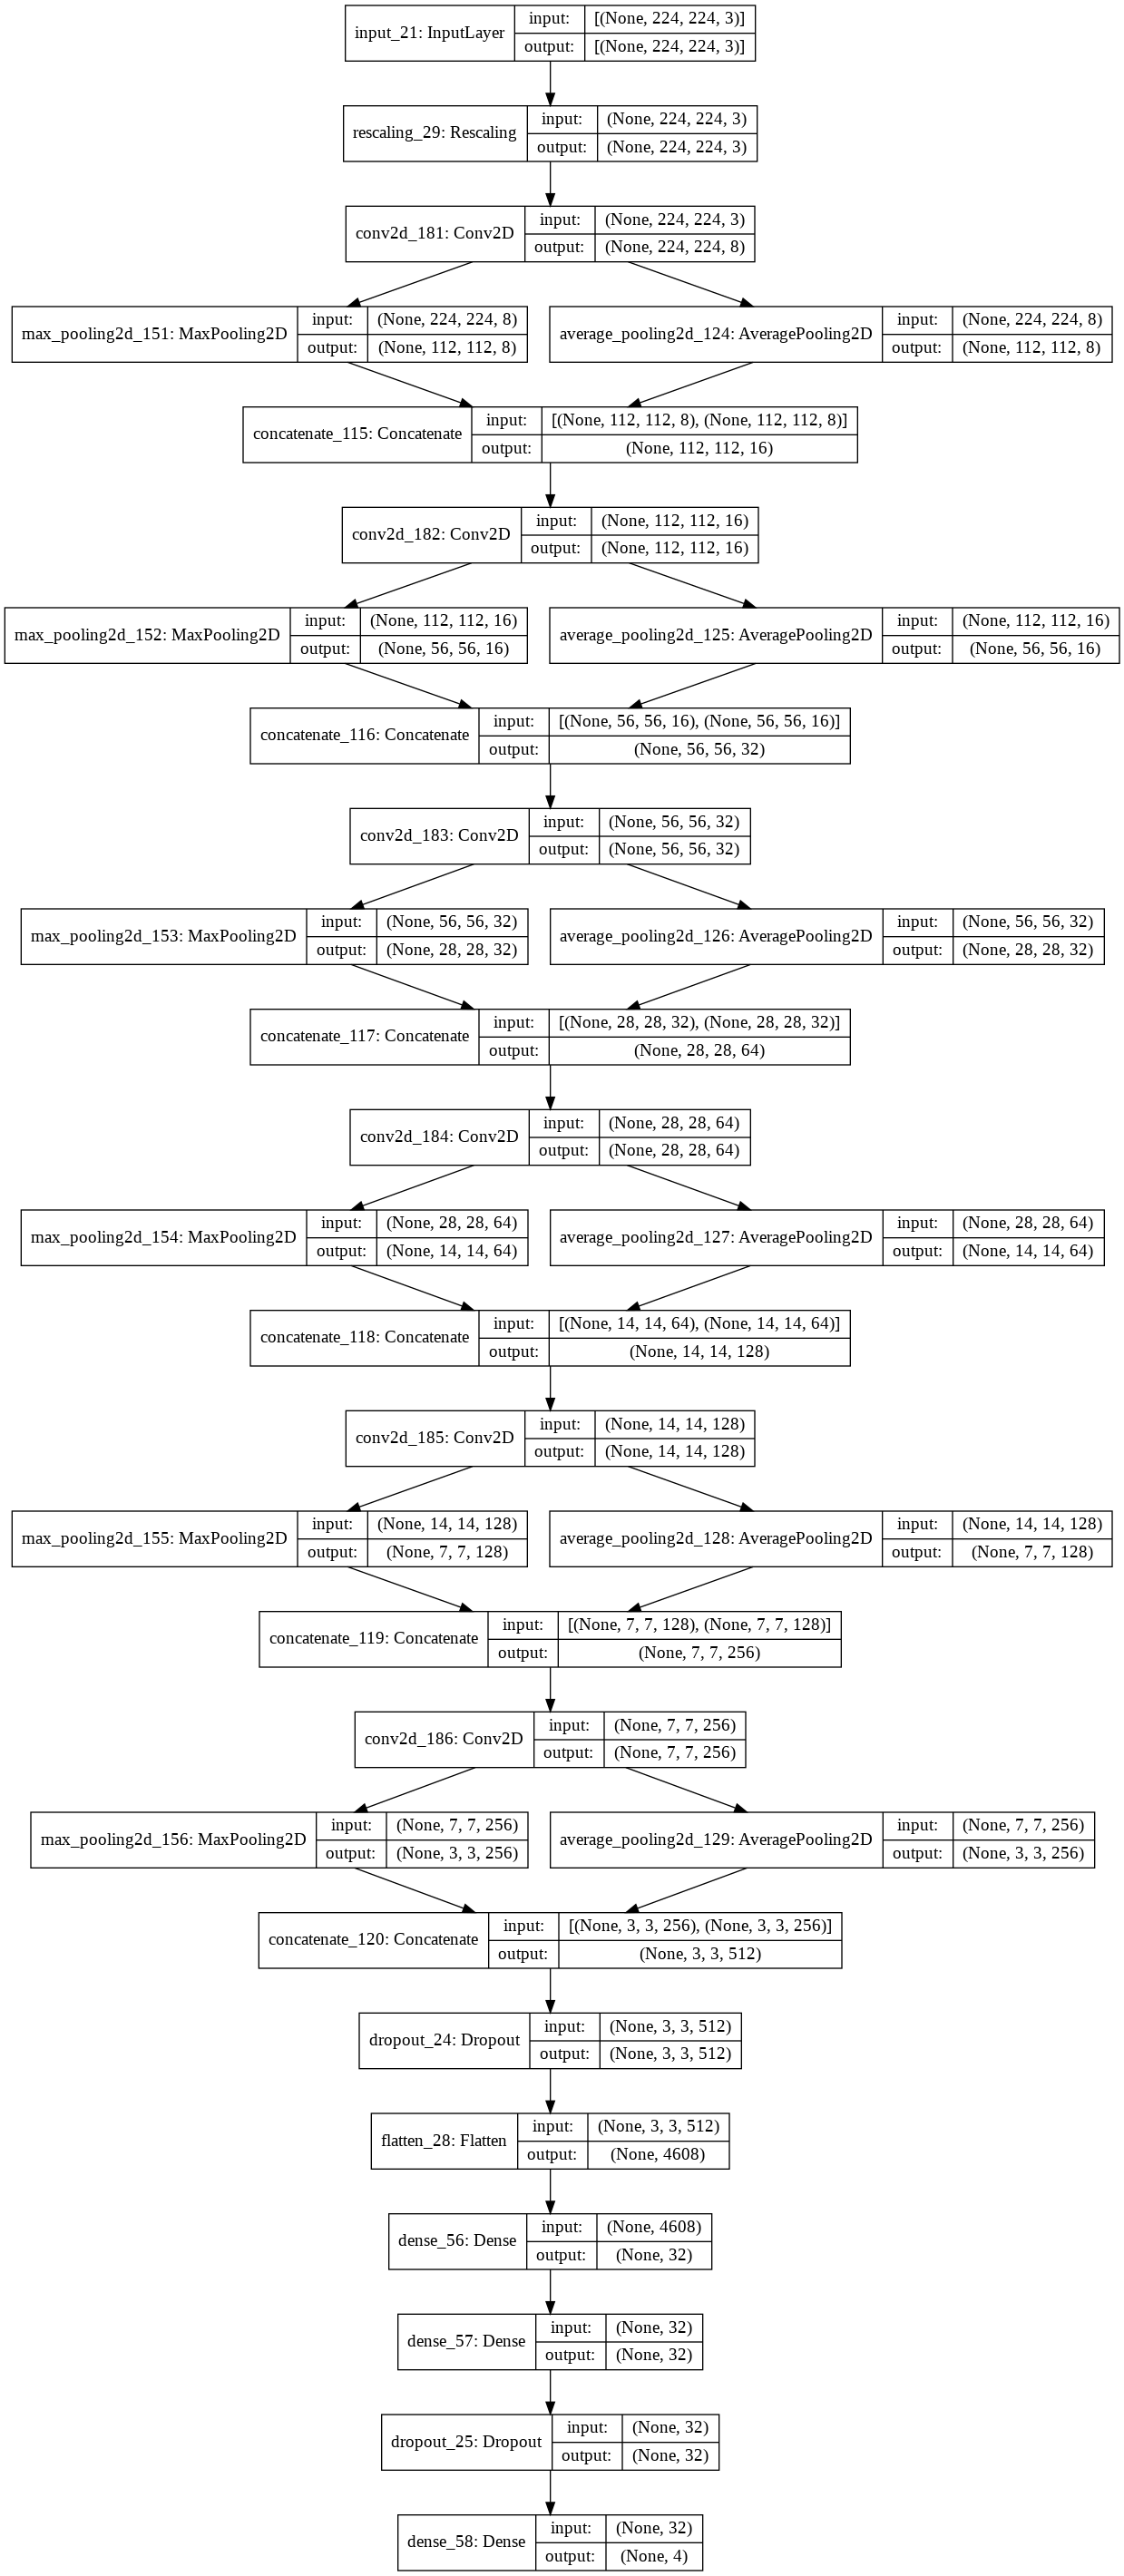

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
def model_global(global_def):

  """
  The parameter global_def defines whether max pool+flatten, global average pooling or global max pooling are applied.

  Arguments: 'Flatten', 'Global Average', 'Global Max', 'Global Avg+Max'
  """
  num_classes = 4

  if global_def=='Flatten':

    i = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i,x)
    
    return model

  if global_def=='Global Average':

    i = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i,x)
    
    return model

  if global_def=='Global Max':

    i = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i,x)
    
    return model
    
  if global_def=='Global Avg+Max':

    i = Input(shape=(image_height, image_width, 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = MaxPool2D()(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = BatchNormalization(momentum=0.6)(x)
    x = hybrid_global_pool_layer()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(i,x)

    return model

In [ ]:
globals = ['Flatten', 'Global Average', 'Global Max', 'Global Avg+Max']
r_globals = dict()


for glob in globals:
  print(f'Training model with {glob} layer')
  model = model_global(global_def=glob)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_globals[glob] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)

Training model with Flatten layer
Epoch 1/30
126/126 [==============================] - 24s 183ms/step - loss: 2.1352 - accuracy: 0.3614 - val_loss: 0.8911 - val_accuracy: 0.5705
Epoch 2/30
126/126 [==============================] - 23s 181ms/step - loss: 0.9890 - accuracy: 0.5004 - val_loss: 0.8365 - val_accuracy: 0.6305
Epoch 3/30
126/126 [==============================] - 23s 181ms/step - loss: 0.8924 - accuracy: 0.5443 - val_loss: 0.8044 - val_accuracy: 0.6754
Epoch 4/30
126/126 [==============================] - 23s 181ms/step - loss: 0.8399 - accuracy: 0.5825 - val_loss: 0.6623 - val_accuracy: 0.7291
Epoch 5/30
126/126 [==============================] - 23s 181ms/step - loss: 0.7823 - accuracy: 0.6249 - val_loss: 0.7075 - val_accuracy: 0.6392
Epoch 6/30
126/126 [==============================] - 23s 181ms/step - loss: 0.7199 - accuracy: 0.6452 - val_loss: 0.8010 - val_accuracy: 0.6679
Epoch 7/30
126/126 [==============================] - 23s 180ms/step - loss: 0.6742 - accuracy: 

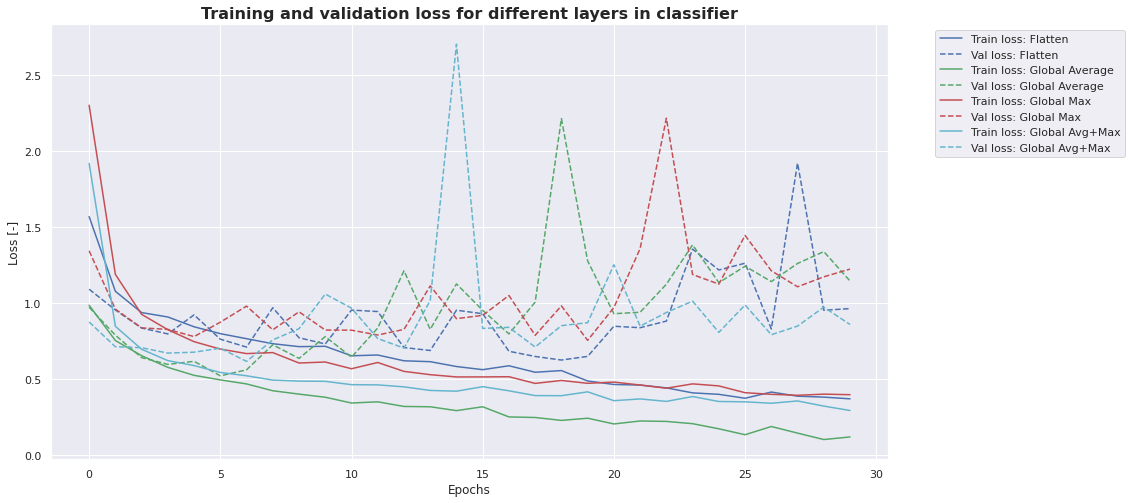

In [ ]:
plot_results_loss(r_globals, 'Training and validation loss for different layers in classifier', 'Train loss', 'Val loss', ['b', 'g', 'r', 'c', 'm'])

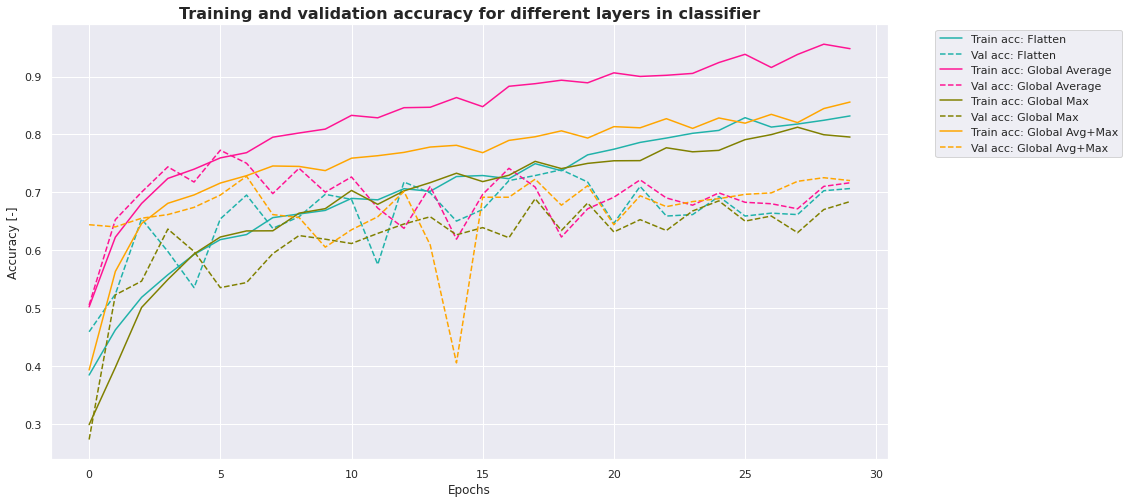

In [ ]:
plot_results_acc(r_globals, 'Training and validation accuracy for different layers in classifier', 'Train acc', 'Val acc', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime'])

In [ ]:
for glob in globals:
  val_acc = round(np.max(r_globals[glob].history['val_accuracy'])*100, 2)
  val_loss = round(np.min(r_globals[glob].history['val_loss']), 2)
  print(f'The best validation accuracy of {glob} is {val_acc}% and validation loss is {val_loss}')

The best validation accuracy of Flatten is 73.91% and validation loss is 0.63
The best validation accuracy of Global Average is 77.28% and validation loss is 0.52
The best validation accuracy of Global Max is 68.91% and validation loss is 0.76
The best validation accuracy of Global Avg+Max is 72.78% and validation loss is 0.62


A concatenated Global Avg+Max layer yields the best results, therefore this configuration will also be used for the following computations. 

###5.3.3 Dense layers

In [ ]:
def model_dense(dense1, dense2):

  """
  
  """
  num_classes = 4

  i = Input(shape=(image_height, image_width, 3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(dense1, activation='relu')(x)
  x = Dense(dense2, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(i,x)
  
  return model

In [ ]:
denses = [32, 64, 128, 256, 512]
r_denses = dict()

for dense in denses:
  print(f'Training model with {dense} neurons in 1st and 2nd layer')
  model = model_dense(dense1=dense, dense2=dense)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  r_denses[dense] = model.fit(ds_train, validation_data=ds_val, epochs=30, class_weight=class_weight_train)

Training model with 32 neurons in 1st and 2nd layer
Epoch 1/30
126/126 [==============================] - 4s 29ms/step - loss: 1.3803 - accuracy: 0.2688 - val_loss: 1.3864 - val_accuracy: 0.1848
Epoch 2/30
126/126 [==============================] - 3s 27ms/step - loss: 1.3870 - accuracy: 0.2442 - val_loss: 1.3856 - val_accuracy: 0.1848
Epoch 3/30
126/126 [==============================] - 3s 27ms/step - loss: 1.3814 - accuracy: 0.2964 - val_loss: 1.3006 - val_accuracy: 0.3708
Epoch 4/30
126/126 [==============================] - 3s 27ms/step - loss: 1.2175 - accuracy: 0.3882 - val_loss: 0.8478 - val_accuracy: 0.5793
Epoch 5/30
126/126 [==============================] - 3s 27ms/step - loss: 0.8853 - accuracy: 0.5338 - val_loss: 0.7223 - val_accuracy: 0.6667
Epoch 6/30
126/126 [==============================] - 3s 27ms/step - loss: 0.7931 - accuracy: 0.5951 - val_loss: 0.6521 - val_accuracy: 0.6904
Epoch 7/30
126/126 [==============================] - 3s 27ms/step - loss: 0.7226 - accura

KeyboardInterrupt: ignored

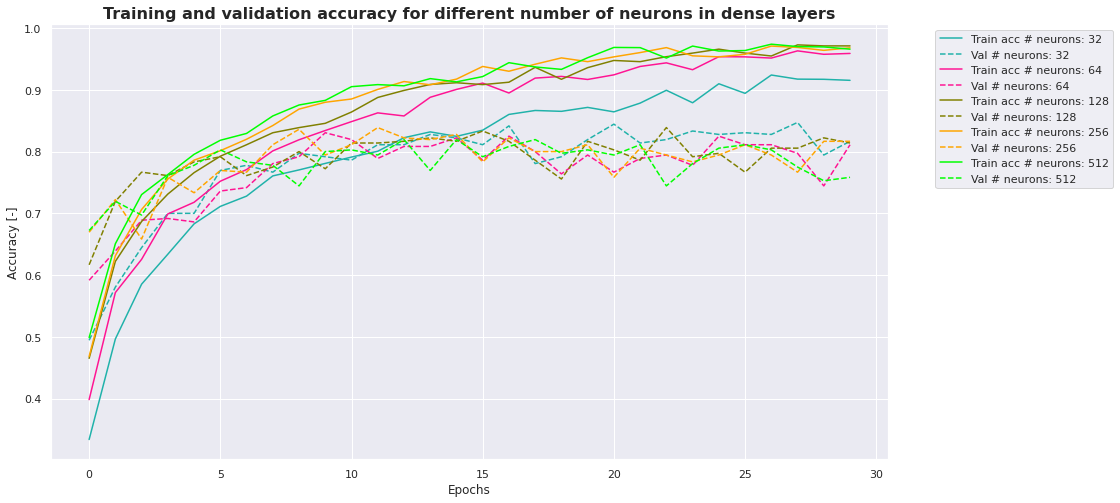

In [ ]:
plot_results_acc(r_denses, 'Training and validation accuracy for different number of neurons in dense layers', 'Train acc # neurons', 'Val acc # neurons', ['lightseagreen', 'deeppink', 'olive', 'orange', 'lime'])

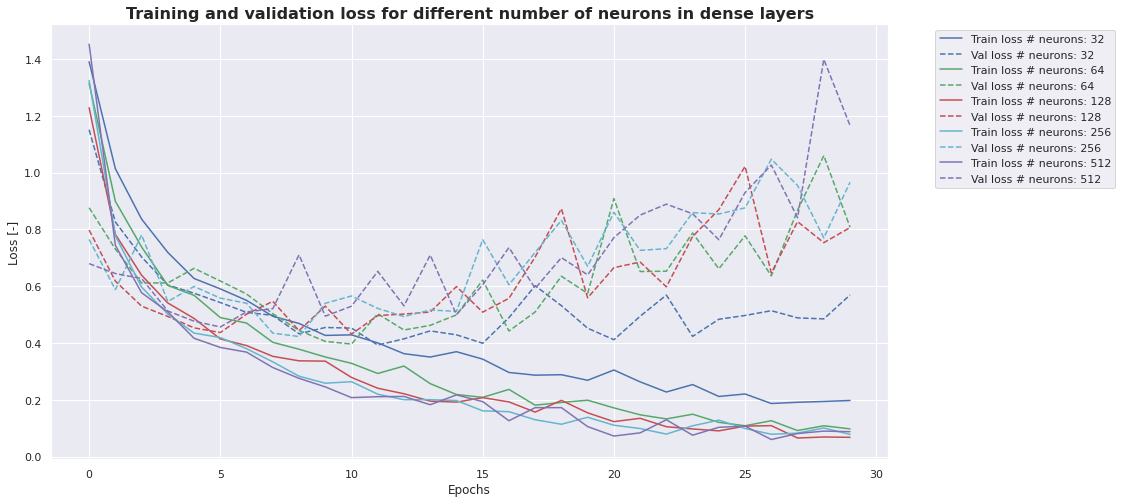

In [ ]:
plot_results_loss(r_denses, 'Training and validation loss for different number of neurons in dense layers', 'Train loss # neurons', 'Val loss # neurons', ['b', 'g', 'r', 'c', 'm'])

#6 Final model from scratch CNN


##6.1 Model structure

In [ ]:
  num_classes = 4

  i = Input(shape=(image_height, image_width, 3))
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(i)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = MaxPool2D()(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
  x = BatchNormalization(momentum=0.6)(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)

  model = Model(i, x)

In [ ]:
  model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 1024, 3)]    0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 512, 1024, 3)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 1024, 16)     448       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 512, 1024, 16)     2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 512, 1024, 16)     64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 512, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 512, 32)      4640

##6.2 Model training

In [ ]:
mcp_save = ModelCheckpoint('gdrive/MyDrive/RSDeepLearning/AssWC/mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='auto', save_weights_only=True)  # we keep saving the best model weights based on validation accuracy

# list together
callbacks = [mcp_save] 

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
r=model.fit(ds_train, validation_data=ds_val, epochs=30,  callbacks=callbacks, class_weight=class_weight_train)

Epoch 1/30
126/126 [==============================] - 132s 730ms/step - loss: 1.2406 - accuracy: 0.3859 - val_loss: 0.8172 - val_accuracy: 0.6592
Epoch 2/30
126/126 [==============================] - 84s 633ms/step - loss: 0.7519 - accuracy: 0.6253 - val_loss: 0.6154 - val_accuracy: 0.7366
Epoch 3/30
126/126 [==============================] - 83s 633ms/step - loss: 0.6471 - accuracy: 0.6915 - val_loss: 0.7482 - val_accuracy: 0.6380
Epoch 4/30
126/126 [==============================] - 83s 636ms/step - loss: 0.5824 - accuracy: 0.7280 - val_loss: 0.8440 - val_accuracy: 0.6092
Epoch 5/30
126/126 [==============================] - 83s 634ms/step - loss: 0.5566 - accuracy: 0.7214 - val_loss: 1.4082 - val_accuracy: 0.5293
Epoch 6/30
126/126 [==============================] - 83s 633ms/step - loss: 0.4942 - accuracy: 0.7595 - val_loss: 0.6088 - val_accuracy: 0.7366
Epoch 7/30
126/126 [==============================] - 83s 635ms/step - loss: 0.5019 - accuracy: 0.7802 - val_loss: 0.5718 - val_a

##6.3 Confusion Matrix

In [ ]:
y_true = np.concatenate([y for x, y in ds_val], axis=0)
x_val = np.concatenate([x for x, y in ds_val], axis=0)
y_pred = model.predict(ds_val).argmax(axis=1)
plt.figure(figsize=(8,8))
plt.grid(False)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, list(range(num_classes)))

##6.4 Statistics (Precision, Recall, F1 score, ROC/AUC curve)

In [ ]:
# Precision, Recall and F1 score
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.16      0.19       290
           1       0.20      0.24      0.22       252
           2       0.35      0.32      0.33       413
           3       0.18      0.25      0.21       193

    accuracy                           0.25      1148
   macro avg       0.24      0.24      0.24      1148
weighted avg       0.26      0.25      0.25      1148



**ROC and AUC**

For each class, we take it as the positive class and group the rest classes together as the negative class.

Class 0 vs classes 1&2
Class 1 vs classes 0&2
Class 2 vs classes 0&1

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y_pred = model.predict(ds_val)
y_true = y_true.reshape(len(y_true), 1)
y_true_onehot = onehot_encoder.fit_transform(y_true)
y_true_onehot = np.array(y_true_onehot)

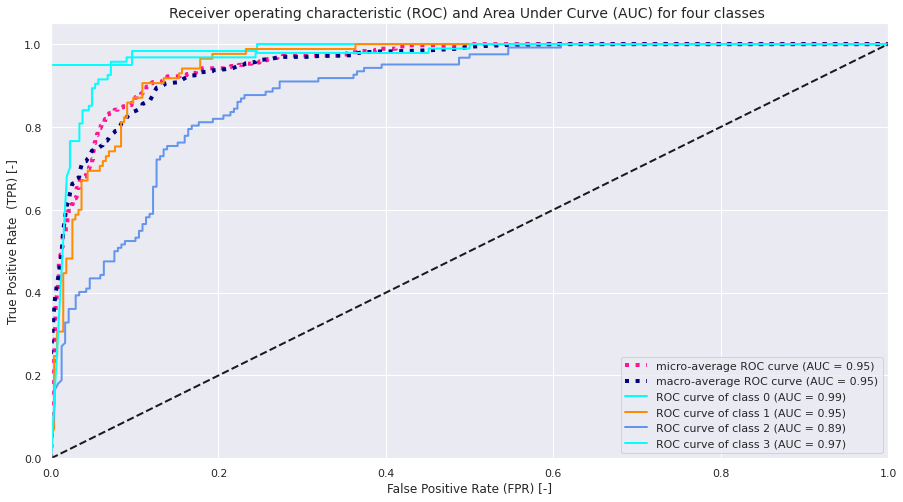

In [ ]:
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR) [-]')
plt.ylabel('True Positive Rate  (TPR) [-]')
plt.title('Receiver operating characteristic (ROC) and Area Under Curve (AUC) for four classes ', fontsize=14)
plt.legend(loc="lower right")
plt.show();

##6.5 Training/Validation loss/accuracy for final CNN model

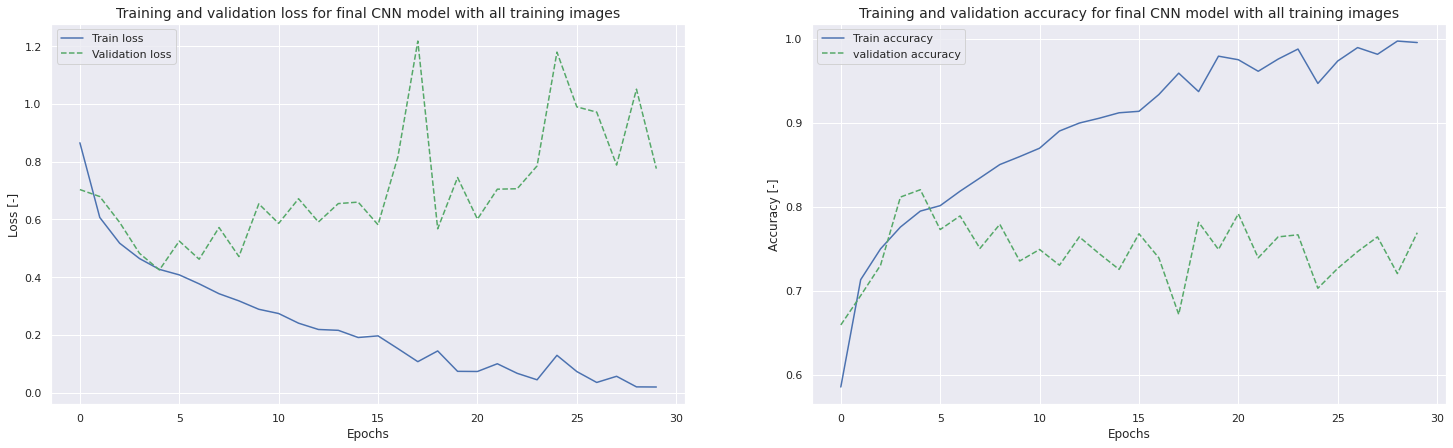

In [ ]:
f, ax = plt.subplots(1,2,figsize=(25,7))
ax[0].plot(r.history['loss'], label = 'Train loss', color = 'b')
ax[0].plot(r.history['val_loss'], label = 'Validation loss', color = 'g', ls= '--')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss [-]')
ax[0].set_title('Training and validation loss for final CNN model with all training images', fontsize=14)
ax[0].legend()
ax[1].plot(r.history['accuracy'], label = 'Train accuracy', color = 'b')
ax[1].plot(r.history['val_accuracy'], label = 'validation accuracy', color = 'g', ls= '--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy [-]')
ax[1].set_title('Training and validation accuracy for final CNN model with all training images', fontsize=14)
ax[1].legend();

##6.6 Misclassified examples

In [ ]:
# label mapping
labels = '''No 
Little 
Moderate 
Lot'''.split()

In [ ]:
x_val=x_val/255.0

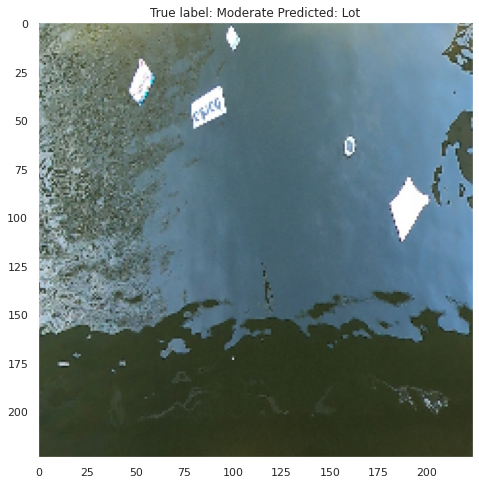

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(y_pred != y_true)[0]
i = np.random.choice(misclassified_idx)
plt.figure(figsize=(10,8))
plt.grid(False)
plt.imshow(x_val[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_true[i]], labels[y_pred[i]]));

#7 Visualization of Feature Maps

In [ ]:
num_classes=4
model_featuremaps = keras.Sequential([
  keras.layers.Conv2D(4, (3,3), strides=1, activation='relu', padding='same', input_shape=(224,224,3)),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(8, (3,3), strides=1, activation='relu', padding='same'), 
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'),
  keras.layers.MaxPool2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model_featuremaps.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [ ]:
# Defining the layer output and feature map model
layer_outputs = [layer.output for layer in model_featuremaps.layers]
feature_map_model = tf.keras.models.Model(inputs=model_featuremaps.input, outputs=layer_outputs)

In [ ]:
# Loading in the image and reshaping it
from tensorflow.keras.preprocessing.image import img_to_array, load_img
image_path= r"gdrive/MyDrive/RSDeepLearning/AssWC/exp54_836_similar.jpg"
img = load_img(image_path, target_size=(224, 224))  
x = img_to_array(img)                           
x = x.reshape(1, 224, 224, 3)                 
x /= 255.0

In [ ]:
# Checking model layers
layer_names=[layer.name for layer in model_featuremaps.layers]
print(layer_names)

['conv2d_6', 'max_pooling2d_6', 'conv2d_7', 'max_pooling2d_7', 'conv2d_8', 'max_pooling2d_8', 'flatten_2', 'dense_2']


In [ ]:
# Model predictiong
feature_maps=feature_map_model.predict(x)

In [ ]:
feature_map_model.summary()

In [ ]:
# Checking the shape of the layers
for layer_name, feature_map in zip(layer_names, feature_maps):
  print(f"The shape of the {layer_name} is =======>> {(feature_map.shape)}")

The shape of the conv2d is =======>> (1, 224, 224, 4)
The shape of the max_pooling2d is =======>> (1, 112, 112, 4)
The shape of the conv2d_1 is =======>> (1, 112, 112, 8)
The shape of the max_pooling2d_1 is =======>> (1, 56, 56, 8)
The shape of the conv2d_2 is =======>> (1, 56, 56, 16)
The shape of the max_pooling2d_2 is =======>> (1, 28, 28, 16)
The shape of the flatten is =======>> (1, 12544)
The shape of the dense is =======>> (1, 4)


In [ ]:
# Visualization of the feature maps per layer which has a length = 4
for layer_name, feature_map in zip(layer_names, feature_maps):
  if len(feature_map.shape) == 4:
    channels=feature_map.shape[-1]  
    size=feature_map.shape[1]
    display_grid=np.zeros((size, size*channels))
    for i in range(channels):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x  
      
    scale = 20. / channels
    plt.figure(figsize=(scale * channels, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, cmap='viridis', aspect='auto')

NameError: ignored

#8 Fine-Tuning Hyperparameters (Keras Tuner)

In [ ]:
pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=aeb78cc0c0791472a16feee261583e23da877aecadaa1302241e71a6990305cd
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=cefa8f34e062e93561852ed5018387a72622e354a73c3bc9e36098218e3609eb
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
  num_classes = 4

  model = keras.models.Sequential()

  model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)))

  #for i in range(hp.Int('n2_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv2_{i}_units', 16, 64, 16), (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'))  
  model.add(keras.layers.Conv2D(16, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.6))  
  model.add(keras.layers.MaxPool2D())

  #for i in range(hp.Int('n3_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv3_{i}_units', 32, 256, 32), (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'))  
  model.add(keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.6))  
  model.add(keras.layers.MaxPool2D())

  #for i in range(hp.Int('n4_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv4_{i}_units', 32, 256, 32), (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(64, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.6)) 
  model.add(keras.layers.MaxPool2D())

  #for i in range(hp.Int('n5_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv5_{i}_units', 32, 256, 32), (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(128, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.6))
  model.add(keras.layers.MaxPool2D()) 

  #for i in range(hp.Int('n5_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv5_{i}_units', 32, 256, 32), (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same'))
  model.add(keras.layers.BatchNormalization(momentum=0.6))
  

  #for i in range(hp.Int('n6_layers', 1, 1)):
    #model.add(keras.layers.Conv2D(hp.Int(f'conv6_{i}_units', 32, 256, 32), (3,3), strides=1, activation='relu', padding='same'))

  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.Dropout(0.5))
  #model.add(keras.layers.Dropout(hp.Choice('drop1', values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))) 
  #keras.layers.Dense(hp.Choice(values=[64, 128, 256, 512]), activation='relu'),
  #keras.layers.Dense(hp.Choice(values=[64, 128, 256, 512]), activation='relu'),
  #keras.layers.Dense(128, activation='relu'),
  #keras.layers.Dense(256, activation='relu'),
  for i in range(hp.Int('n_layers', 1, 4)):
    keras.layers.Dense(hp.Choice('dense1', values=[16, 32, 64, 128, 256, 512]), activation='relu'),
    keras.layers.Dense(hp.Choice('dense2', values=[16, 32, 64, 128, 256, 512]), activation='relu'),
  model.add(keras.layers.Dropout(0.5))
  #model.add(keras.layers.Dropout(hp.Choice('drop2', values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7])))  
  model.add(keras.layers.Dense(num_classes, activation='softmax'))

  #model.add(keras.layers.GlobalAveragePooling2D())
  #model.add(keras.layers.Dropout(0.2))
  
  #for i in range(hp.Int('n_layers', 1, 4)):
  #keras.layers.Dense(hp.Choice('dense1', values=[16, 32, 64, 128, 256, 512]), activation='relu'),
  #keras.layers.Dense(hp.Choice('dense2', values=[16, 32, 64, 128, 256, 512]), activation='relu'),

  #model.add(keras.layers.Dropout(0.3))
  #model.add(keras.layers.Dense(num_classes, activation='softmax'))

  #hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    overwrite=True
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(ds_train,
             validation_data=ds_val,
             epochs=20,
             callbacks=[stop_early],
             class_weight=class_weight_train)

Trial 11 Complete [00h 03m 47s]
val_accuracy: 0.7652933597564697

Best val_accuracy So Far: 0.7827715277671814
Total elapsed time: 00h 46m 30s

Search: Running Trial #12

Hyperparameter    |Value             |Best Value So Far 
n_layers          |2                 |3                 
dense1            |128               |256               
dense2            |512               |32                

Epoch 1/20
 91/126 [====================>.........] - ETA: 5s - loss: 1.2902 - accuracy: 0.4131

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
best_hps.get('learning_rate')

0.001

In [ ]:
best_hps.get('dense2')

256

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 24)      672       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       1736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 48)      3504      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 224)       9